In [539]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [540]:
df = pd.read_csv('./data/gugraon_properties_post_feature_selection.csv')
df.head(2)

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category,price
0,0.0,40.0,3.0,2.0,2.0,1.0,850.0,0.0,0.0,0.0,1.0,1.0,0.82
1,0.0,101.0,2.0,2.0,2.0,1.0,1226.0,1.0,0.0,0.0,1.0,2.0,0.95


In [541]:
df.info()
# are actually categorical features
# property_type, sector, balcony, agePossessionm, furnishing_type, luxury_category, floor_category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_type    3554 non-null   float64
 1   sector           3554 non-null   float64
 2   bedRoom          3554 non-null   float64
 3   bathroom         3554 non-null   float64
 4   balcony          3554 non-null   float64
 5   agePossession    3554 non-null   float64
 6   built_up_area    3554 non-null   float64
 7   servant room     3554 non-null   float64
 8   store room       3554 non-null   float64
 9   furnishing_type  3554 non-null   float64
 10  luxury_category  3554 non-null   float64
 11  floor_category   3554 non-null   float64
 12  price            3554 non-null   float64
dtypes: float64(13)
memory usage: 361.1 KB


In [542]:
X = df.drop(columns=['price'])
y = df['price']

In [543]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

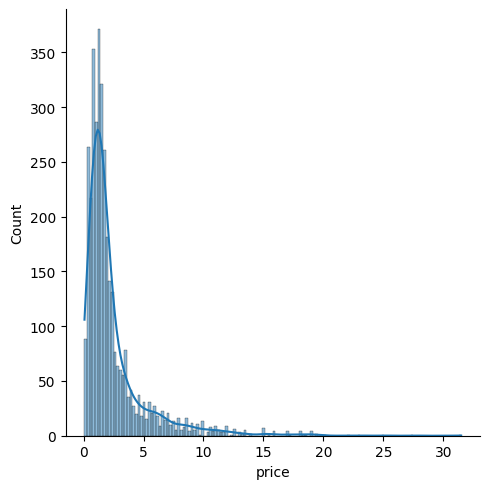

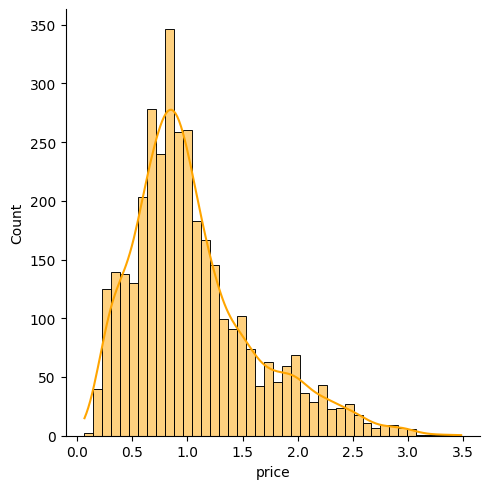

In [544]:
# apply log1p transformation to the output column 'price', 
# as leaned during univariate analysis
#y_transformed = np.log(y) + 2
y_transformed = np.log1p(y)
sns.displot(y, kde=True)
sns.displot(y_transformed, kde=True, color='orange')
plt.show()

In [545]:
cat_column_to_encode =  ['sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']
num_column_to_stand = ['property_type', 'bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']

In [546]:
# ceating column transformer for different columns
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_column_to_stand),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_column_to_encode)
    ],
remainder='passthrough'
)

In [547]:
# create a pipeline to execute things in a flow
# pipeline = Pipeline([('preprocessor', preprocessor),
#                      ('regressor', LinearRegression())
#                      ])

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('regressor', SVR(kernel='rbf'))
                     ])

# pipeline = Pipeline([('preprocessor', preprocessor),
#                      ('regressor', KNeighborsRegressor(n_neighbors=15))
#                      ])

# pipeline = Pipeline([('preprocessor', preprocessor),
#                      ('regressor',  RandomForestRegressor(n_estimators=100, random_state=42))
#                      ])
# pipeline = Pipeline([('preprocessor', preprocessor),
#                      ('regressor',  Lasso(alpha=0.1, random_state=42))
#                      ])

In [548]:
# KFold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, scoring='r2', cv=kfold)
scores

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([0.89625507, 0.89890161, 0.89699437, 0.87650964, 0.88208773,
       0.89182046, 0.88658219, 0.89815548, 0.84960368, 0.86942495])

In [549]:
scores.mean()
# Very good score

0.8846335176532033

In [550]:

scores.std()
# low std is good

0.015035261784859142

Check if the error in prediction is low while doing train-test split

In [551]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, random_state=42)

In [552]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['property_type', 'bedRoom',
                                                   'bathroom', 'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sector', 'balcony',
                                                   'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', SVR())])

In [553]:
y_pred = pipeline.predict(X_test)

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [554]:
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
#score = mean_absolute_error(np.exp(y_test-2), np.exp(y_pred-2))
score

0.5368288920892123